# Unconditional image generation

Unconditional image generation is a relatively straightforward task. The model only generates images - without any additional context like text or an image - resembling the training data it was trained on.

The [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) is the easiest way to use a pre-trained diffusion system for inference.

Start by creating an instance of [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) and specify which pipeline checkpoint you would like to download.
You can use any of the Diffusers [checkpoints](https://huggingface.co/models?library=diffusers&sort=downloads) from the Hub (the checkpoint you'll use generates images of butterflies).

TIP:

In this notebook, you'll use [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) for unconditional image generation with [DDPM](https://arxiv.org/abs/2006.11239) (Denoising Diffusion Probabilistic Models):

In [1]:
!pip3 install transformers

In [2]:
!pip3 install accelerate

In [3]:
import transformers

In [4]:
!pip install diffusers

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
from pprint import pprint
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
from transformers import TFAutoModelForMaskedLM, AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer, top_k_top_p_filtering
from torch import nn
from accelerate import Accelerator
from diffusers import DiffusionPipeline

In [6]:
generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128")

unet/diffusion_pytorch_model.safetensors not found


The [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) downloads and caches all modeling, tokenization, and scheduling components.
Because the model consists of roughly 1.4 billion parameters, we strongly recommend running it on a GPU.
You can move the generator object to a GPU, just like you would in PyTorch:

In [7]:
generator.to("cuda")

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.18.0",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

Now you can use the `generator` to generate an image:

In [8]:
image = generator().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

The output is by default wrapped into a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=image#the-image-class) object.

You can save the image by calling:

In [9]:
image.save("generated_image.png")

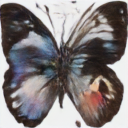

In [10]:
image

In [11]:
image1 = generator().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

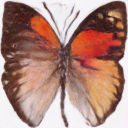

In [12]:
image1

Try out the Spaces below, and feel free to play around with the inference steps parameter to see how it affects the image quality!

<iframe
	src="https://stevhliu-ddpm-butterflies-128.hf.space"
	frameborder="0"
	width="850"
	height="500"
></iframe>

https://huggingface.co/docs/diffusers/using-diffusers/unconditional_image_generation




---



---



---



---



**Improving the quality of the image by adding more information to the prompt**

In [13]:
import PIL
from PIL import Image

A common way to improve the quality of generated images is with deterministic batch generation, generate a batch of images and select one image to improve with a more detailed prompt in a second round of inference. The key is to pass a list of torch.Generator’s to the pipeline for batched image generation, and tie each Generator to a seed so you can reuse it for an imag

In [74]:
prompt = "Labrador jumping"

In [75]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Now, define four different Generator’s and assign each Generator a seed (0 to 3) so you can reuse a Generator later for a specific image:

In [76]:
generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]

Create the four images of an aussie shepherd jumping

In [77]:
images = pipe(prompt, generator=generator, num_images_per_prompt=4).images

  0%|          | 0/50 [00:00<?, ?it/s]

A function to display the images in a grid

In [78]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [79]:
all_images = []
for _ in range(2):
    images = pipe(prompt, num_images_per_prompt=2, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Display the four images in a grid

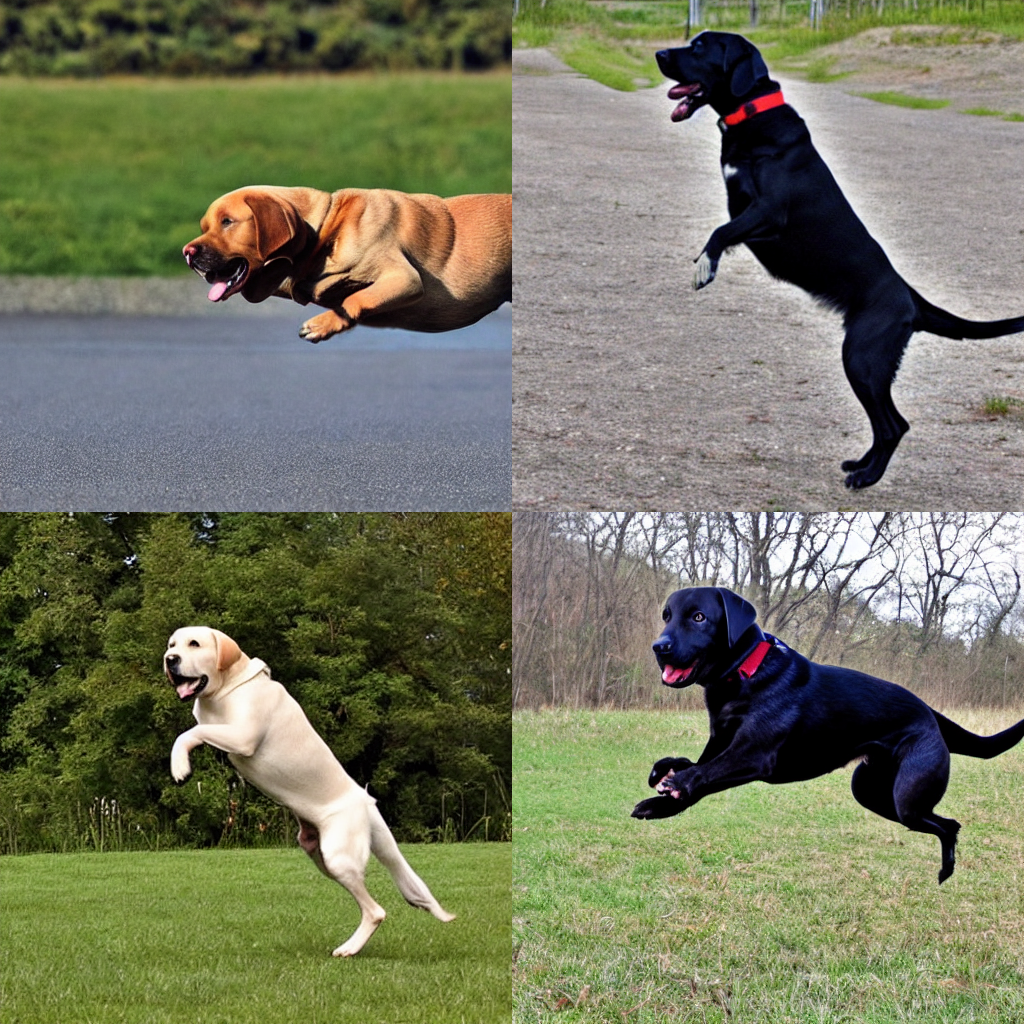

In [80]:
grid = image_grid(all_images, 2,2)
grid

In this example, you’ll improve upon the first image - but in reality, you can use any image you want.<br>

The first image used the Generator with seed 0, so you’ll reuse that Generator for the second round of inference. <br>

To improve the quality of the image, add some additional text to the prompt:

manual_seed[0] -- means begin with generator used for the first image.

In [81]:
generator = [torch.Generator(device="cuda").manual_seed(0) for i in range(4)]

In [84]:
prompt = "Labrador jumping"
print(prompt)

Labrador jumping


In [88]:
promptList = [" over a fence", " over a bone", " over a creek", " over a car"]

Create the new prompts then use the generator to create the images

In [89]:
promptNew=[]
promptNew.clear()
#promptNew = [prompt + t for t in promptList[t]]
for i in range(4):
  new=prompt+promptList[i]
  promptNew.append(new)
  print(promptNew[i])

Labrador jumping over a fence
Labrador jumping over a bone
Labrador jumping over a creek
Labrador jumping over a car


Create new versions of the first image uainf

In [90]:
imagesNew = pipe(promptNew, generator=generator).images

  0%|          | 0/50 [00:00<?, ?it/s]

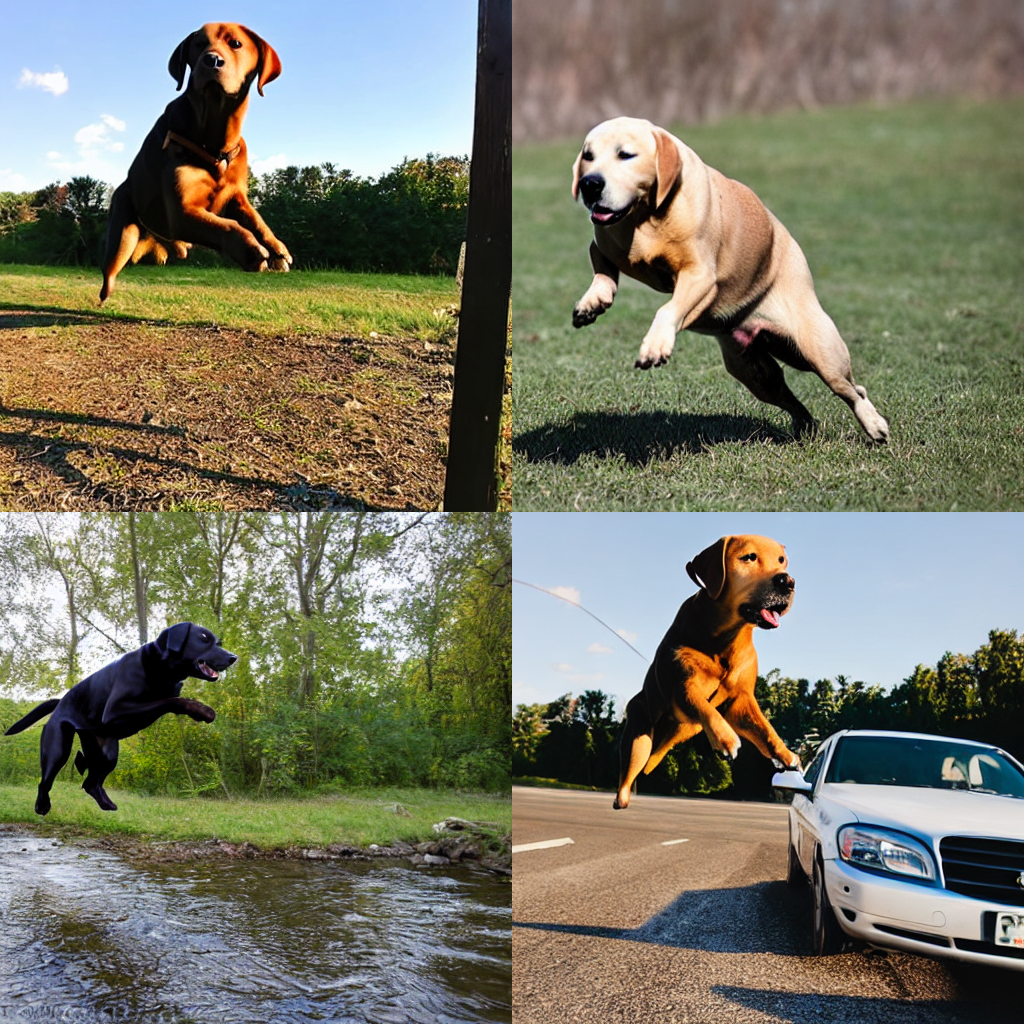

In [91]:
grid = image_grid(imagesNew, 2, 2)
grid

In [109]:
promptList = [", photograph", ", painting", ", hyperrealistic", ", tie dye"]

In [110]:
prompt = "Labrador jumping"
print(prompt)

Labrador jumping


In [111]:
promptStyle=[]
promptStyle.clear()
for i in range(4):
  new=prompt+promptList[i]
  promptStyle.append(new)
  print(promptStyle[i])

Labrador jumping, photograph
Labrador jumping, painting
Labrador jumping, hyperrealistic
Labrador jumping, tie dye


In [112]:
imagesNew = pipe(promptStyle, generator=generator).images

  0%|          | 0/50 [00:00<?, ?it/s]

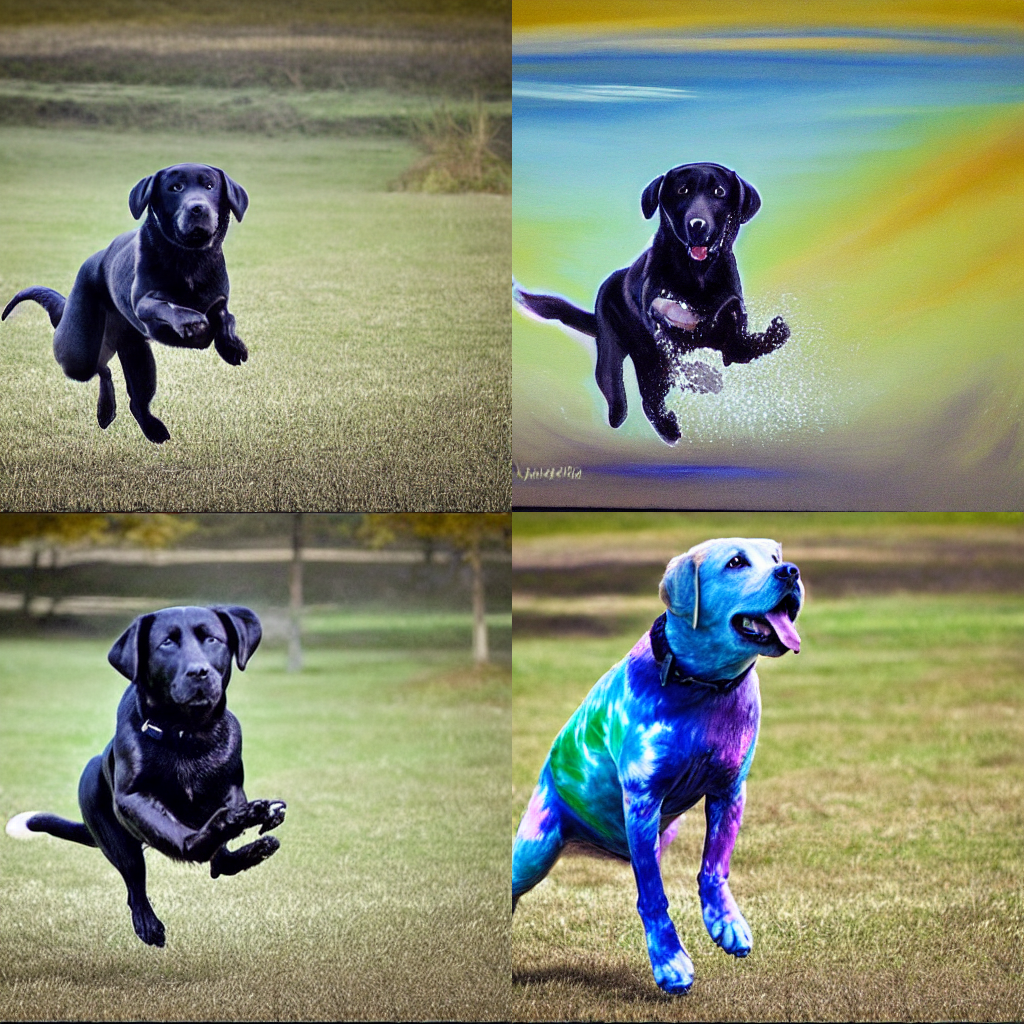

In [113]:
grid = image_grid(imagesNew, 2, 2)
grid